In [2]:
from PISNml import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
cols = ['A','B','C','err','points','max_flux']
nb_extra = 0   #Number of extra parameter that you dont want to plot
band_used = [2,3,4,5]
nb_band = len(band_used)
nb_param = len(cols)
nb_trees = 1000


sample = 'Silver/'
PISN_split = '-1_'
curve = 'Complete/'
model = 'poly'
purpose = 'test'

In [4]:
data = pd.read_pickle("../../plasticc/param_table/"+sample+curve+purpose+PISN_split+model+".pkl")

In [5]:
table_iso, table_score = create_if(data,[2,3,4,5],6,nb_trees)

score2 : OK
score3 : OK
score4 : OK
score5 : OK


In [6]:
table_iso

,object_id,target,0,1,2,3,4,5,score2,6,...,16,17,score4,18,19,20,21,22,23,score5
0,13,42,8.315272e-07,-0.000220,0.003228,0.941658,52.0,24.529644,0.092765,1.165023e-06,...,51.0,42.765503,0.058863,1.072700e-06,-0.000159,-0.043651,1.206321,51.0,36.802090,0.080336
1,14,42,1.043327e-06,-0.001082,0.218847,0.744413,52.0,14.465278,0.080761,1.713310e-06,...,51.0,9.230726,0.023599,-1.526946e-07,-0.000130,0.206442,3.259098,51.0,14.839427,0.080221
2,17,42,4.641806e-07,-0.000197,0.031918,0.974416,58.0,12.973317,0.115799,3.850994e-07,...,58.0,12.109291,0.098541,-7.538624e-09,0.000478,-0.124074,4.022734,57.0,16.761280,0.092406
3,23,90,-1.426843e-06,0.001406,-0.089316,2.543105,52.0,5.387752,0.048053,-2.227311e-06,...,51.0,21.272690,0.067095,-1.984103e-06,0.001726,-0.117388,1.459547,51.0,28.061138,0.058846
4,34,90,-1.172269e-06,0.001073,-0.069684,1.124961,58.0,124.475609,-0.017218,-1.110185e-06,...,58.0,111.523895,-0.002280,-1.041445e-06,0.000971,-0.090383,1.267607,57.0,90.760689,0.014313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32694,342818,67,-1.374100e-06,0.001175,-0.057490,0.710243,56.0,72.033432,0.040291,-1.861249e-06,...,56.0,141.229965,-0.023766,-1.948159e-06,0.001664,-0.082198,0.921868,55.0,121.277580,-0.014339
32695,342825,42,4.998490e-07,0.000145,-0.047420,2.457405,56.0,4.396688,0.102014,1.184399e-06,...,56.0,13.672332,0.119827,1.682807e-06,-0.000857,0.050437,1.620999,56.0,21.398048,0.111334
32696,342834,90,9.304841e-07,-0.001215,0.359726,1.074035,56.0,35.456642,0.080228,9.692496e-07,...,56.0,44.910275,0.078133,1.040203e-06,-0.001412,0.461396,1.638422,56.0,49.754597,0.062010
32697,342860,42,1.064644e-06,-0.000517,0.051827,1.109443,45.0,22.257574,0.065517,1.126362e-06,...,45.0,17.354675,0.038744,-4.200380e-08,0.000130,0.014748,0.553154,45.0,97.282578,0.027529


In [7]:
band = 5
top_score = table_iso.loc[:,['score'+str(band),'target','object_id']].sort_values(by ='score'+str(band), ignore_index=True)
top994 = top_score[top_score['target']==994]
top994['threshold(%)'] = 100*top994.index/len(top_score);
top994

<ipython-input-7-cb21cd95536c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top994['threshold(%)'] = 100*top994.index/len(top_score);


,score5,target,object_id,threshold(%)
36,-0.218283,994,341607,0.110095
316,-0.119430,994,145664,0.966390
5034,0.007499,994,330535,15.394966
5534,0.012453,994,107780,16.924065
6367,0.019979,994,230192,19.471543
15750,0.067742,994,339196,48.166611


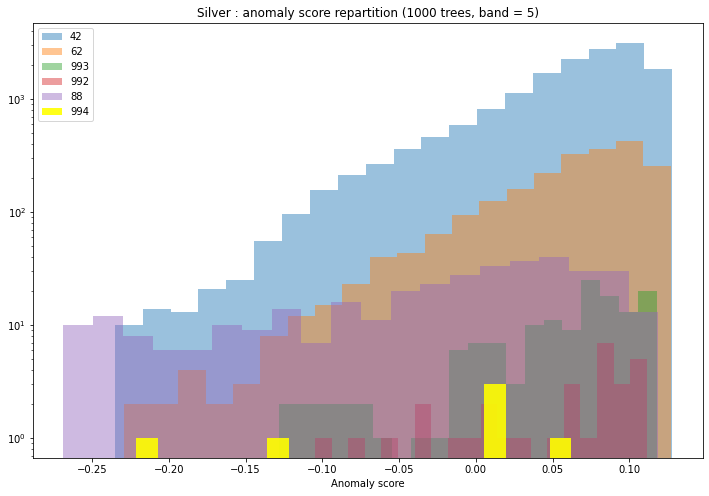

In [45]:
band = 5

plt.figure(figsize = (12,8))
plt.yscale("log")


targetofinterest = [42,62,993,992,88]


plt.title('Silver : anomaly score repartition (1000 trees, band = %s)'%(str(band)))
for i in targetofinterest:
    plt.hist(top_score.loc[top_score['target']==i,'score'+str(band)],bins=20,label = i,alpha = 0.45);

plt.hist(top_score.loc[top_score['target']==994,'score'+str(band)],bins=20,label = 994,alpha = 0.9,color = 'yellow');
plt.xlabel('Anomaly score')
plt.legend()
#plt.savefig("Silver_hist_anomaly(1000t_5b).png")